In [253]:
import pandas as pd
import numpy as np
import sys
import nltk
import re
from nltk.probability import FreqDist
from nltk.util import ngrams
import collections
from collections import Counter, defaultdict
from nltk import trigrams
from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rahulmenon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rahulmenon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rahulmenon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulmenon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [254]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)
    

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    print("Correct predictions %d"%(ok))
    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():

        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1
        
        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

In [255]:
def load_data_dataframe(path):
    df = pd.read_csv(path ,sep='\t')
    return df

In [256]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

In [257]:
df = load_data_dataframe('/Users/rahulmenon/Downloads/MSc DA/Term 1/NLP/Assignment 2/semeval-tweets/twitter-training-data.txt')

In [258]:
df[0:10]

,335104872099066692,positive,Felt privileged to play Foo Fighters songs on guitar today with one of the plectrums from the gig on Saturday.
0,796528524030124618,positive,"@AaqibAfzaal Pakistan may be an Islamic country, but der are a lot true Muslims in India who love their country and can sacrifice all for it"
1,760964834217238632,positive,Happy Birthday to the coolest golfer in Bali! @tjvictoriacnd !! :) may you become cooler and cooler everyday! Stay humble little sister! Xx
2,147713180324524046,negative,@SimpplyA TMILLS is going to Tucson! But the 29th and it's on a Thursday :(
3,732302280474120023,negative,Hmmmmm where are the #BlackLivesMatter when matters like this a rise... kids are a disgrace!! https://t.co/aPrB0VtvCN
4,724826707518822134,positive,"@Hypable all good, I'm excited about a 3rd season finding home on Netflix. Just want to make sure the readers have the news as it develops"
5,134322773956255784,positive,"I told my mom I wanted to stay in a hotel for my 18th with people, but my birthdays on Valentine's :-)) lucky me"
6,73060048261791634,positive,1st thing I did after baggage claim was get up to date with @RonnaAndBeverly. Bad Blood Ronna &amp; Bev style makes being home a bit more okay
7,855586456869811926,negative,Bobby Jindal wants you to assimilate to heritage of the old confederacy even though his parents are from January dot dot dot
8,225466624830593540,positive,@coolcat1304 I watched it 4 the 1st time & :-). Voted 4 it in the NTA awards - best Factual program. Mite need 2 watch rest on itvplayer
9,33620536146652095,negative,@LilBeast03 I'm sad that Naruto (manga) is over and I'll probably cry when the anime ends. Kishimoto-san is coming to the US in October!!


In [259]:
print(df.shape)

(45025, 3)


In [260]:
new_header = ['id','sentiment','content']
df.columns = new_header

<AxesSubplot:>

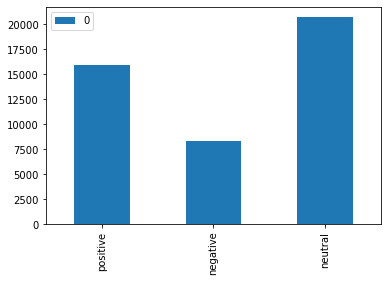

In [261]:
sentiment_counter = Counter(df['sentiment'].values.tolist())
df_sent = pd.DataFrame.from_dict(sentiment_counter, orient='index')
df_sent.plot(kind='bar')

In [380]:
def clean_data(data):
    data['clean'] = data['content']
    # Remove all URLs
    data['clean'] = data['clean'].apply(lambda x : re.sub(r"http\S+", '', x))
    data['clean'] = data['clean'].apply(lambda x : re.sub(r"www\.\S+", '', x))

    #Remove all RTs
    data['clean'] = data['clean'].apply(lambda x : re.sub(r"RT",'',x))

    #change to lowercase
    data['clean'] = data['clean'].str.lower()

    #Remove usernames (@xxxxxx)
    data['clean'] = data['clean'].apply(lambda x : re.sub(r"@[^\s]+",'',x))

    #Remove hashtags (#xxxxxx)
    data['clean'] = data['clean'].apply(lambda x : re.sub(r"#",'',x))
    
    #Remove short words like is Im etc. that doesnt provide much information to the classifier
    data['clean'] = data['clean'].apply(lambda x : re.sub(r'\b\w{1,3}\b', '', x))

    #Remove all non alphnumeric characters
    data['clean'] = data['clean'].apply(lambda x : re.sub(r"[^a-zA-Z0-9\s]",'',x))


In [381]:
clean_data(df)

In [382]:
lm = nltk.stem.WordNetLemmatizer()
# lemmatize and remove stop words from the content
def removeStopWords(sentence):
    words = nltk.word_tokenize(sentence)
    words = [ lm.lemmatize(word) for word in words if ( word not in set(stopwords.words('english')) and len(word) > 1) ]
    words = ' '.join(words)
    return words

In [383]:
df['clean'] = df['clean'].apply(lambda x : removeStopWords(x))

In [384]:
print((df['clean']))

0                                 pakistan islamic country true muslim india love country sacrifice
1        happy birthday coolest golfer bali become cooler cooler everyday stay humble little sister
2                                                                 tmills going tucson 29th thursday
3                                             hmmmmm blacklivesmatter matter like rise kid disgrace
4                      good excited season finding home netflix want make sure reader news develops
                                                    ...                                            
45020        sunday cinema paul mccartney david gilmour paul mccartney continues stay former member
45021                                          independence sacrifice muslim victory pakistan proud
45022                         september arrived mean apple iphone hour away becoming official thing
45023                                   tomorrow filled feeding league prolly skull smashing batman


In [385]:
# Fit a TF-IDF vectorizer to the training data
# ngrams of lengths 1,2 and 3 will be used while creating the features before training the model
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english",min_df=3,max_df=0.9,ngram_range=(1,3))
X = tfidf.fit(df['clean'])
X = tfidf.transform(df['clean']).toarray()

In [386]:
ids_train = df['id'].astype('str')

In [387]:
print(X.shape)

(45025, 23980)


In [388]:
# use LabelEncoder from scickit learn to encode the dependent variable sentiment into labels 0,1,2 for negative,neutral and positive respectively
encoder = LabelEncoder()
sentiment_encoded = encoder.fit_transform(df['sentiment'])
df['sentiment_encoded'] = sentiment_encoded

In [389]:
# Set the Y array to be the encoded sentiments
y = df['sentiment_encoded']

In [390]:
data = load_data_dataframe('/Users/rahulmenon/Downloads/MSc DA/Term 1/NLP/Assignment 2/semeval-tweets/twitter-dev-data.txt')
data.columns = new_header
clean_data(data)
data.head()

,id,sentiment,content,clean
0,410734138242126311,positive,Literally so excited I'm going to a Sam Smith concert in October,literally excited going smith concert october
1,237615985571058688,neutral,@WINDmobile Will there be an option to buy the 2GB of RAM model of the Moto G (3rd Gen) instead of the 1GB model?,will there option model moto instead model
2,90473590077188360,neutral,Our Little Ms. Philippines. 👏👏👏#littleMsPhilippines #unitednations https://t.co/kQK64D0d75,little philippines littlemsphilippines unitednations
3,450236582392850660,negative,"@AngryRaiderFan I know. This, TPP, expanded wars and drone strikes, mass surveillance, on and on...",know this expanded wars drone strikes mass surveillance
4,686031506093676865,positive,@rinashah I have been using Moto G 2nd Gen for over a month now and it's an absolute delight. Stock Android. Good design. Best.,have been using moto over month absolute delight stock android good design best


In [391]:
data['clean'] = data['clean'].apply(lambda x : removeStopWords(x))

In [392]:
X_test = tfidf.transform(data['clean']).toarray()

In [393]:
print(X_test.shape)
ids_test = data['id'].astype('str')

(1999, 23980)


In [394]:
sentiment_encoded_test = encoder.fit_transform(data['sentiment'])
data['sentiment_encoded'] = sentiment_encoded_test
y_test = data['sentiment_encoded']

## Naive Bayes Classifier

In [395]:
# Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
sentiment_analyser = MultinomialNB().fit(X, y)

In [396]:
y_pred_NB = sentiment_analyser.predict(X)

In [397]:
id_preds_train = dict(zip(ids_train,encoder.inverse_transform(y_pred_NB)))

In [398]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(confusion_matrix(y,y_pred_NB))
accuracy_score(y,y_pred_NB)

[[ 3017  4227  1073]
 [  472 17692  2585]
 [   94  4255 11610]]


0.7178012215435869

In [399]:
evaluate(id_preds_train, '/Users/rahulmenon/Downloads/MSc DA/Term 1/NLP/Assignment 2/semeval-tweets/twitter-training-data.txt', 'Naive Bayes')

Correct predictions 31073
/Users/rahulmenon/Downloads/MSc DA/Term 1/NLP/Assignment 2/semeval-tweets/twitter-training-data.txt (Naive Bayes): 0.579


In [400]:
y_pred_test = sentiment_analyser.predict(X_test)

In [401]:
id_preds_test = dict(zip(ids_test,encoder.inverse_transform(y_pred_test)))

In [402]:
evaluate(id_preds_test, '/Users/rahulmenon/Downloads/MSc DA/Term 1/NLP/Assignment 2/semeval-tweets/twitter-dev-data.txt', 'Naive Bayes')

Correct predictions 1179
/Users/rahulmenon/Downloads/MSc DA/Term 1/NLP/Assignment 2/semeval-tweets/twitter-dev-data.txt (Naive Bayes): 0.449


[[ 91 242  45]
 [ 24 717 177]
 [  4 297 402]]


0.6053026513256629

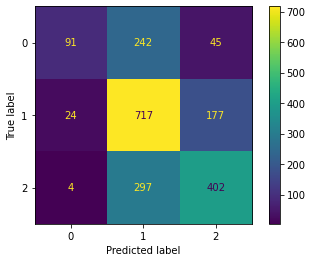

In [403]:
print(confusion_matrix(y_test,y_pred_test))
plot_confusion_matrix(sentiment_analyser, X_test, y_test)
accuracy_score(y_test,y_pred_test)

## SVM Classifier

In [404]:
from sklearn import svm
from sklearn.metrics import classification_report

In [405]:
sentiment_analyser_SVM = svm.LinearSVC()

In [406]:
sentiment_analyser_SVM.fit(X,y)

LinearSVC()

In [407]:
y_pred_test = sentiment_analyser_SVM.predict(X_test)

In [408]:
id_preds_test = dict(zip(ids_test,encoder.inverse_transform(y_pred_test)))

0.6238119059529765
Correct predictions 1210
/Users/rahulmenon/Downloads/MSc DA/Term 1/NLP/Assignment 2/semeval-tweets/twitter-dev-data.txt (SVM): 0.550


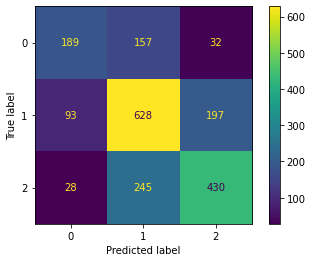

In [409]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_test,y_pred_test))
evaluate(id_preds_test, '/Users/rahulmenon/Downloads/MSc DA/Term 1/NLP/Assignment 2/semeval-tweets/twitter-dev-data.txt', 'SVM')
plot_confusion_matrix(sentiment_analyser_SVM, X_test, y_test)

## LSTM classifier

In [410]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.data import Field, LabelField,TabularDataset, BucketIterator

In [411]:
from torchtext.data.utils import get_tokenizer
import spacy
spacy.cli.download('en_core_web_sm')
spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [412]:
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [413]:
df_lstm = pd.DataFrame(columns=['text','labels'])
df_lstm_test = pd.DataFrame(columns=['text','labels'])

In [414]:
df_lstm['text'] = df['clean']
df_lstm_test['text'] = data['clean']

In [415]:
df_lstm['labels'] = df['sentiment']
df_lstm_test['labels'] = data['sentiment']

In [416]:
df_lstm.to_csv('train.csv',index=False)
df_lstm_test.to_csv('test.csv',index=False)

In [417]:
df_lstm.head()

,text,labels
0,pakistan islamic country true muslim india love country sacrifice,positive
1,happy birthday coolest golfer bali become cooler cooler everyday stay humble little sister,positive
2,tmills going tucson 29th thursday,negative
3,hmmmmm blacklivesmatter matter like rise kid disgrace,negative
4,good excited season finding home netflix want make sure reader news develops,positive


In [418]:
TWEET = Field(tokenize = tokenizer)
SENTIMENT = LabelField(dtype = torch.long)

In [419]:
#reading again using tabular dataset
datafields=[('text', TWEET),('labels', SENTIMENT)]
train,test = TabularDataset.splits(path='',train='train.csv',test='test.csv',format='csv',skip_header=True, fields=datafields)

In [420]:
print(vars(train.examples[1]))

{'text': ['happy', 'birthday', 'coolest', 'golfer', 'bali', 'become', 'cooler', 'cooler', 'everyday', 'stay', 'humble', 'little', 'sister'], 'labels': 'positive'}


In [421]:
TWEET.build_vocab(train, max_size=5000, min_freq = 5, vectors='glove.6B.100d', unk_init=torch.Tensor.normal_)
SENTIMENT.build_vocab(train)

In [422]:
TWEET.vocab.itos[:10]

['<unk>',
 '<pad>',
 'tomorrow',
 'night',
 'going',
 'like',
 'time',
 'sunday',
 'friday',
 'game']

In [423]:
TWEET.vocab.freqs.most_common(20)

[('tomorrow', 5858),
 ('night', 2533),
 ('going', 2518),
 ('like', 2396),
 ('time', 2333),
 ('sunday', 2181),
 ('friday', 2110),
 ('game', 1646),
 ('saturday', 1566),
 ('want', 1540),
 ('monday', 1507),
 ('make', 1427),
 ('today', 1421),
 ('know', 1400),
 ('good', 1356),
 ('think', 1246),
 ('tonight', 1231),
 ('come', 1227),
 ('last', 1145),
 ('still', 1135)]

In [424]:
SENTIMENT.vocab.stoi

defaultdict(None, {'neutral': 0, 'positive': 1, 'negative': 2})

In [425]:
print(f"Nuber of unique tokens in tweet vocabulary: {len(TWEET.vocab)}")
print(f"Number of unique tokens in sentiment vocabulary: {len(SENTIMENT.vocab)}")

Nuber of unique tokens in tweet vocabulary: 5002
Number of unique tokens in sentiment vocabulary: 3


In [426]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [427]:
device

device(type='cpu')

In [428]:
print(vars(train.examples[0]))

{'text': ['pakistan', 'islamic', 'country', 'true', 'muslim', 'india', 'love', 'country', 'sacrifice'], 'labels': 'positive'}


In [429]:
train_iterator, test_iterator = BucketIterator.splits(
      (train, test),
      batch_size = 100,
      device = device,
      sort_key = lambda x: len(x['text']),
    )

In [430]:
test_iterator

In [432]:
for i,batch in enumerate(train_iterator):
    print(batch.text)

tensor([[387, 114, 206,  ..., 177,  28,  63],
        [936,  25,  93,  ..., 519, 137, 121],
        [578,   0, 248,  ..., 851, 396, 389],
        ...,
        [  1,   1,   1,  ...,   1, 428,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]])
tensor([[1827, 1570, 2067,  ...,  458, 2131,  128],
        [ 966,   37, 2874,  ...,  271,    0,    5],
        [ 434, 1853,  249,  ...,   15,  819,    0],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
tensor([[  11,    0,  959,  ...,  437,   45,  114],
        [ 171,    0,   58,  ...,  751,   40,    0],
        [ 125, 3267,  114,  ..., 4081,  139,    0],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
tensor([[  22,  915,  296,  ...,   24, 1421,   48],
      

tensor([[   0,  599,   29,  ...,  595,  519,   23],
        [ 190,  294,  380,  ...,    5, 1388, 3464],
        [  78,    0, 4912,  ...,   88,   16,  479],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
tensor([[ 602,   56,   26,  ...,  664, 2121,    0],
        [   9,  319,  328,  ...,   57, 3470,  352],
        [4543, 3432, 1616,  ...,  789,  367, 2198],
        ...,
        [   1,    1,  148,  ...,    1,    1,    1],
        [   1,    1, 3977,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
tensor([[ 568, 3637,  248,  ...,   18, 1550,  167],
        [2112,  960, 1125,  ...,    0,    0,    0],
        [2176,   56,    0,  ...,    0,   54, 3756],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
tensor([[ 144,   95,  

tensor([[ 435,    0,  369,  ..., 2427,  146,    0],
        [ 783,    0, 2559,  ...,  343, 1649,  686],
        [ 709, 2440,  478,  ...,  445,  572,   68],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
tensor([[ 637,  331,    0,  ...,    0,    0,  977],
        [  16,  530,    2,  ...,  112, 3480,  250],
        [   1,    0,    0,  ...,  421,    7,   66],
        ...,
        [   1,   19,    1,  ...,    1, 2712,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
tensor([[1582, 1797,    0,  ...,  516, 2978,  699],
        [   0,  433,   10,  ..., 1609,  418, 1986],
        [4712,  169,  107,  ...,    0,  643,  320],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
tensor([[  35,    0,  

In [434]:
class Model_LSTM(nn.Module):
    def __init__(self, input_size, output_size, embedding_size, hidden_size, n_layers, dropout):
        super(Model_LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size) # matrix of shape (max_words,embedding_dim)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout = dropout)

        #Define 2 fully connected layers with hidden_dim input dimension for layer 1 and hidden_dim//2 for layer 2
        self.layer_1 = nn.Linear(hidden_size, hidden_size//2)
        self.layer_2 = nn.Linear(hidden_size//2, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text)) 
        output, (hidden, cell) = self.rnn(embedded) 
        output = self.layer_1(output[-1])
        output = self.layer_2(self.relu(output))
        return output


In [435]:
TWEET.vocab.vectors

tensor([[ 0.6808,  2.3850,  0.8080,  ...,  0.4439,  0.7998, -0.8016],
        [ 1.3065,  1.2072,  0.5054,  ..., -0.3680, -0.9530, -0.0321],
        [ 0.0085,  0.1802,  0.7703,  ...,  0.2993,  0.4085,  0.4761],
        ...,
        [-0.4090, -0.2604,  0.1009,  ..., -0.2215, -0.0058,  0.3542],
        [-0.4253, -0.1090,  0.4407,  ..., -0.5796,  1.1028, -0.2753],
        [ 0.4501,  0.5961,  0.2167,  ..., -0.0065,  1.3071,  0.0821]])

In [436]:
# Hyperparameters
input_size = len(TWEET.vocab) #number of tokens = 5002
output_size = len(SENTIMENT.vocab) #number of sentiments = 3
embedding_dim = 100  #For glove 6d with 100 features
hidden_dim = 32
number_of_layers = 2
dropout = 0.25

# Create model instance
model = Model_LSTM(input_size, output_size, embedding_dim, hidden_dim, number_of_layers, dropout)
if(torch.load('LSTM_Sent_Analyser.pt')):
    model.load_state_dict(torch.load('LSTM_Sent_Analyser.pt'))
model.to(device)
# Copy the pre-trained Glove word embedding 
model.embedding.weight.data.copy_(TWEET.vocab.vectors) 

tensor([[ 0.6808,  2.3850,  0.8080,  ...,  0.4439,  0.7998, -0.8016],
        [ 1.3065,  1.2072,  0.5054,  ..., -0.3680, -0.9530, -0.0321],
        [ 0.0085,  0.1802,  0.7703,  ...,  0.2993,  0.4085,  0.4761],
        ...,
        [-0.4090, -0.2604,  0.1009,  ..., -0.2215, -0.0058,  0.3542],
        [-0.4253, -0.1090,  0.4407,  ..., -0.5796,  1.1028, -0.2753],
        [ 0.4501,  0.5961,  0.2167,  ..., -0.0065,  1.3071,  0.0821]])

### Optimizer setup and model training

In [437]:
optimizer = optim.Adam(model.parameters())

#Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, verbose=True)
criterion = nn.CrossEntropyLoss()

def train_model(model, iterator, criterion = criterion, optimizer = optimizer, clip = 1):
    model.train()
    current_loss = 0
    total_true = 0
    total = 0
    
    for i,batch in enumerate(iterator):
        text = batch.text.to(device)
        labels = batch.labels.to(device)
        optimizer.zero_grad()
        
        output = model(text)
        
        total_true += torch.sum(torch.eq(output.argmax(1), labels))
        total += len(labels)

        loss = criterion(output, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        current_loss += loss.item()
        
    print(f'correct predictions : {total_true} out of {total}')
    mean_loss = current_loss / len(iterator)
    scheduler.step(mean_loss)
    return mean_loss

In [438]:
import matplotlib.pyplot as plt

Running Epoch 0
correct predictions : 26299 out of 45025
 Loss : 0.883793
Running Epoch 1
correct predictions : 29077 out of 45025
 Loss : 0.781796
Running Epoch 2
correct predictions : 30264 out of 45025
 Loss : 0.735128
Running Epoch 3
correct predictions : 30865 out of 45025
 Loss : 0.704601
Running Epoch 4
correct predictions : 31455 out of 45025
 Loss : 0.678994
Running Epoch 5
correct predictions : 31935 out of 45025
 Loss : 0.655826
Running Epoch 6
correct predictions : 32477 out of 45025
 Loss : 0.630451
Running Epoch 7
correct predictions : 33019 out of 45025
 Loss : 0.612080
Running Epoch 8
correct predictions : 33408 out of 45025
 Loss : 0.591770
Running Epoch 9
correct predictions : 33885 out of 45025
 Loss : 0.572337
Running Epoch 10
correct predictions : 34360 out of 45025
 Loss : 0.552268
Running Epoch 11
correct predictions : 34641 out of 45025
 Loss : 0.537581
Running Epoch 12
correct predictions : 34917 out of 45025
 Loss : 0.522150
Running Epoch 13
correct prediction

Text(0, 0.5, 'Training Loss')

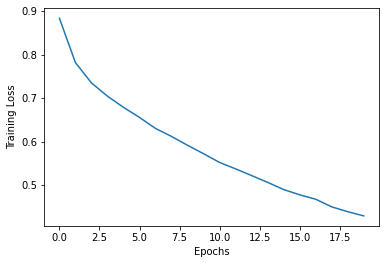

In [439]:
# Set number of epochs and train the model

epochs = 20
losses = []
for epoch in range(epochs):
    print('Running Epoch %d'%(epoch))
    loss = train_model( model = model, iterator = train_iterator)
    print(' Loss : %f'%(loss))
    losses.append(loss)

plt.plot(np.array(losses))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')


In [484]:
# Save the model
torch.save(model.state_dict(), 'LSTM_Sent_Analyser.pt')

In [485]:
def convert_to_tensor(sentence):
    #sent_tokenized = [ word.TWEET for word in tokenizer(sentence) ]
    in_data = [TWEET.vocab.stoi[word.lower()] for word in sentence]
    #in_data = torch.tensor(in_data, dtype=torch.long)
    return in_data

In [487]:
print(test.examples[0].text)

['literally', 'excited', 'going', 'smith', 'concert', 'october']


### Test the cereated model

In [488]:
test_iterator = BucketIterator(test, batch_size = 100, device = device)
criterion = nn.CrossEntropyLoss()
total_true = 0
total = 0
current_loss = 0
for i,batch in enumerate(test_iterator) :
    text = batch.text.to(device)
    labels = batch.labels.to(device)
    output = model(text)
    total_true += torch.sum(torch.eq(output.argmax(1), labels))
    total += len(labels)
    loss = criterion(output,labels)
    current_loss += loss.item()
print(f'correct predictions : {total_true} out of {total}')
mean_loss = current_loss / len(test_iterator)
scheduler.step(mean_loss)
print(mean_loss)

correct predictions : 1237 out of 1999
1.0594580441713333


In [480]:
print(output)
print(len(output.argmax(1).squeeze(0)))

tensor([[ 3.8674e-01,  5.4679e-01, -1.5239e+00],
        [ 1.4929e+00, -5.6152e-01, -1.8041e+00],
        [ 2.6873e+00, -3.4001e+00, -6.5466e-01],
        [-8.7307e-01, -4.3580e+00,  3.7480e+00],
        [ 7.3453e-01,  7.1474e-01, -2.3971e+00],
        [ 2.9468e+00, -3.0995e+00, -1.3315e+00],
        [ 4.4038e+00, -3.0203e+00, -4.0357e+00],
        [ 2.2602e+00, -4.2228e+00,  8.4866e-01],
        [ 1.7446e+00,  2.7976e-01, -3.4635e+00],
        [ 3.8642e+00, -2.4122e+00, -3.6117e+00],
        [ 1.3285e+00, -3.9883e+00,  1.6005e+00],
        [-1.2931e+00,  4.6008e+00, -3.7638e+00],
        [ 1.6520e+00,  9.0324e-01, -4.1697e+00],
        [ 4.1847e-01,  1.1142e+00, -2.4731e+00],
        [-1.7819e-01,  8.7034e-01, -9.5496e-01],
        [-1.0707e+00,  4.3998e+00, -4.1004e+00],
        [ 1.3058e+00, -4.6284e+00,  2.1557e+00],
        [ 1.3183e+00, -4.9005e-01, -1.5800e+00],
        [-1.4714e+00,  4.1250e+00, -2.8216e+00],
        [-4.9047e-01, -2.2724e+00,  1.9178e+00],
        [-1.2783e+00